# Implementation For Europe
## State Variable:

- Prices: Euro Stoxx 50 (Bloomberg)
- Volatility: realised + Implied on Euro Stoxx 50
- 10 year rate: 10 year german bond (assumed that german bond is a benchmark for europe) (FRED)
- 3 month rate: 3 month German bond (FRED)
- Oil: brent crude oil futures (Bloomberg)
- Copper: Copper future prices (Bloomberg)

Used also Fama French Factors to evaluate the performance for now,

## Results: 
The signal seems to hold in this market too, Maha distance seems also to contribute to better performance (higher SR) and also clearer economic interpretation giving more performance from first quantile.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import seaborn as sns

os.chdir(r"C:\Users\kelvi\Documents\Berkeley\Term 2\Projects")
data = pd.read_excel("Regimes\Data\Europe\europe state variable.xlsx")
fred_3m = (pd.read_excel("Regimes\Data\Europe\Germ3m.xlsx").rename(columns={
                              "Germ3m": "ThreeMonth"}))               
fred_3m["Date"]       = pd.to_datetime(fred_3m["Date"])
fred_3m["ThreeMonth"] = pd.to_numeric(fred_3m["ThreeMonth"], errors="coerce")
fred_3m["Month"]      = fred_3m["Date"].dt.to_period("M")

fred_10y = (pd.read_excel("Regimes\Data\Europe\Germ10y.xlsx")      
              .rename(columns={"10y": "TenYear"}))

fred_10y["Date"]   = pd.to_datetime(fred_10y["Date"])
fred_10y["TenYear"] = pd.to_numeric(fred_10y["TenYear"], errors="coerce")
fred_10y["Month"]  = fred_10y["Date"].dt.to_period("M")


non_date_cols = [c for c in data.columns if c != "Dates"]

data = data.dropna(axis=0, how="all", subset=non_date_cols)
data.head()

,Dates,Euro_Stoxx_Price,Germ10y,Germ3m,Brent_Crude_Oil_future,Copper_future,Copper_future_2,Euribor3m,Vol_Euro_Stoxx
15132,1986-12-31,900.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15133,1987-01-01,900.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15134,1987-01-02,891.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15135,1987-01-05,898.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15136,1987-01-06,902.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN


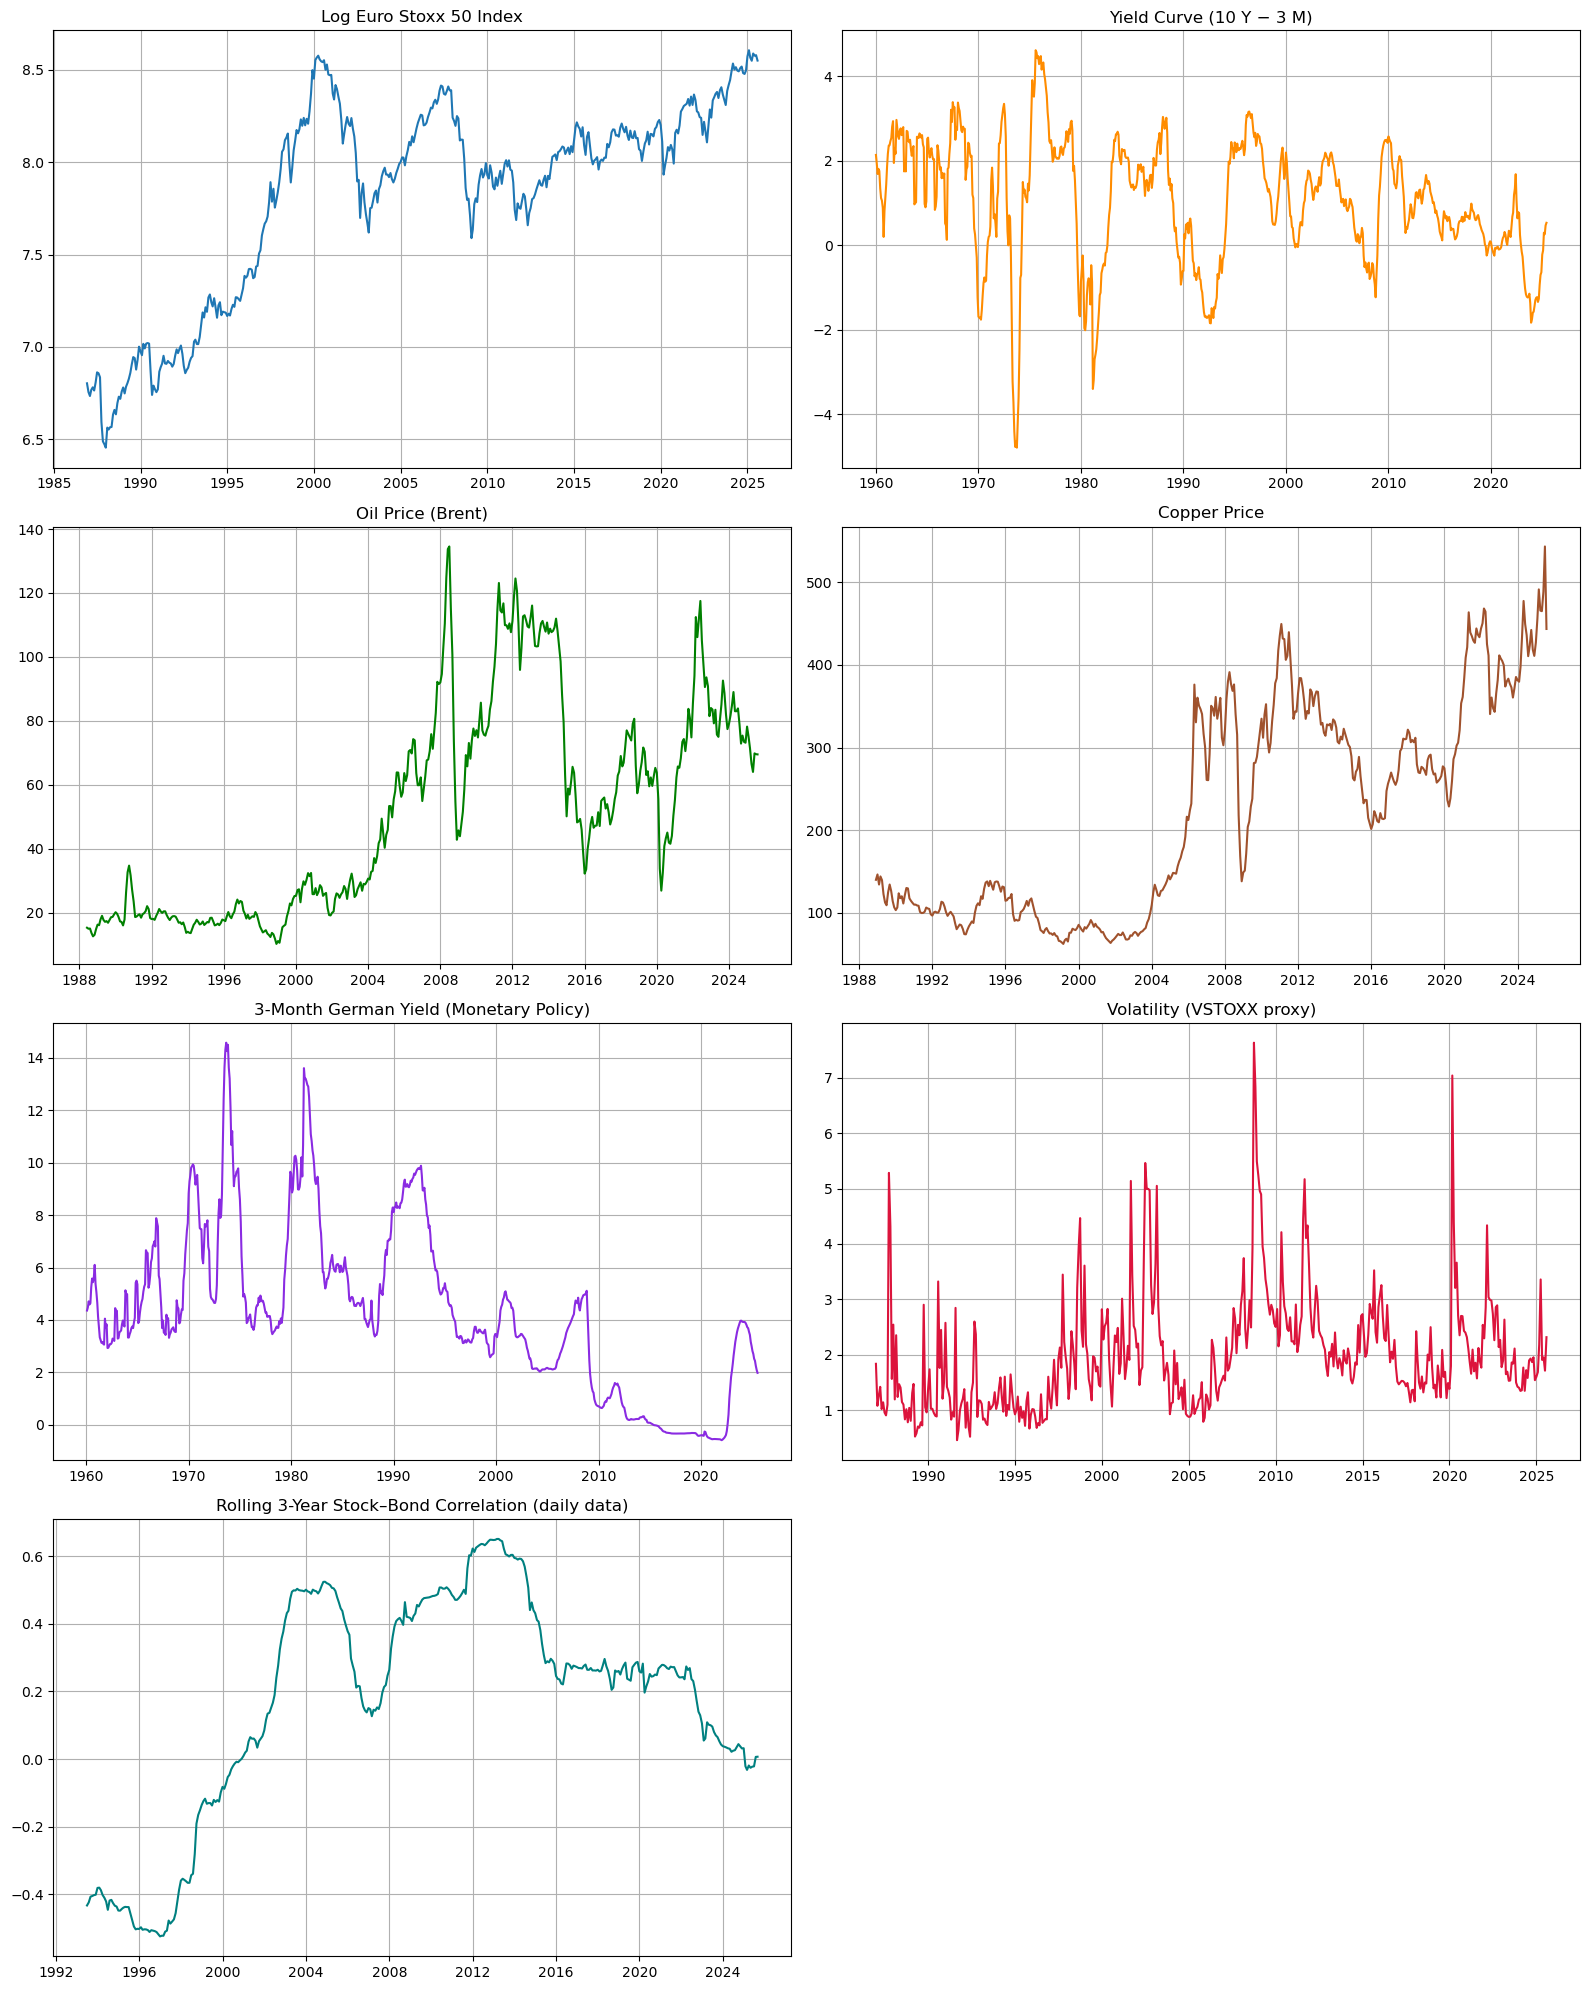

In [2]:
df = data.copy().rename(columns={"Dates": "Date"})
df["Date"] = pd.to_datetime(df["Date"])

# ----------------------------------------------------------------------
# 1. Euro Stoxx 50 (daily ➜ monthly prices & returns)
# ----------------------------------------------------------------------
df["ret"] = np.log(df["Euro_Stoxx_Price"]).diff()
df["Month"] = df["Date"].dt.to_period("M")

eurostoxx_monthly = (df.groupby("Month")
                       .tail(1)
                       .reset_index(drop=True))

eurostoxx_monthly["EuroStoxx_Return"] = np.log(eurostoxx_monthly["Euro_Stoxx_Price"]).diff()
eurostoxx_monthly["Log_EuroStoxx"] = np.log(eurostoxx_monthly["Euro_Stoxx_Price"])

var_mkt_eur = eurostoxx_monthly[["Month", "Euro_Stoxx_Price",
                                 "EuroStoxx_Return", "Log_EuroStoxx"]].copy()

# ----------------------------------------------------------------------
# 2. German 10-Year Yield (daily ➜ monthly)
# ----------------------------------------------------------------------
tenyear_monthly = (fred_10y
                     .groupby("Month")["TenYear"]
                     .mean()
                     .reset_index())

# ----------------------------------------------------------------------
# 3. German 3-Month Yield (daily ➜ monthly)
# ----------------------------------------------------------------------
var_3m_eur = (fred_3m
                .groupby("Month")["ThreeMonth"]
                .mean()
                .reset_index())    

# ----------------------------------------------------------------------
# 4. Yield-Curve Variables
# ----------------------------------------------------------------------
merged_eur = (tenyear_monthly
                .merge(var_3m_eur, on="Month", how="inner")
                .sort_values("Month"))

merged_eur["YieldCurve"]  = merged_eur["TenYear"] - merged_eur["ThreeMonth"]
merged_eur["YieldChange"] = merged_eur["TenYear"].diff()


# ----------------------------------------------------------------------
# 5. Brent Crude Oil (monthly average)
# ----------------------------------------------------------------------
df["Brent_Crude_Oil_future "] = pd.to_numeric(df["Brent_Crude_Oil_future "], errors="coerce")
oil_monthly_eur = (df.groupby("Month")["Brent_Crude_Oil_future "]
                     .mean()
                     .reset_index()
                     .rename(columns={"Brent_Crude_Oil_future ": "Oil Price"}))

# ----------------------------------------------------------------------
# 6. Copper (monthly average)
# ----------------------------------------------------------------------
df["Copper_future"] = pd.to_numeric(df["Copper_future"], errors="coerce")
df["Copper_future_2"] = pd.to_numeric(df["Copper_future_2"], errors="coerce")

copper_monthly_eur = (df.groupby("Month")["Copper_future"]
                        .mean()
                        .reset_index()
                        .rename(columns={"Copper_future": "Copper"}))
# ----------------------------------------------------------------------
# 6. Volatility
# ----------------------------------------------------------------------
vix_monthly_eur = (df.groupby("Month")["Vol_Euro_Stoxx"]
                     .mean()
                     .div(10)                  
                     .rename("VolProxy")
                     .dropna()             
                     .reset_index())

first_vol_month_eur = vix_monthly_eur["Month"].min()

realised_eur = (
    df.loc[df["Month"] < first_vol_month_eur]
      .groupby("Month")["ret"]
      .agg(lambda x: x.std(ddof=0) * np.sqrt(252) * 10)   
      .to_frame("VolProxy")
      .reset_index()
)

combined_vol_eur = (pd.concat([realised_eur, vix_monthly_eur], axis=0)
                      .sort_values("Month")
                      .reset_index(drop=True))


# ----------------------------------------------------------------------
# 8. Stock–Bond Correlation (daily ➜ monthly)
# ----------------------------------------------------------------------
df_daily_eur = df[["Date", "ret", "Germ10y"]].dropna().copy()
df_daily_eur["d_y"] = df_daily_eur["Germ10y"].diff() / 100.0
df_daily_eur.dropna(inplace=True)

window_days = 252 * 3
df_daily_eur["StockBondCorr"] = (df_daily_eur["ret"]
                                   .rolling(window_days)
                                   .corr(df_daily_eur["d_y"]))

df_daily_eur["Month"] = df_daily_eur["Date"].dt.to_period("M")
var_correl_eur = (df_daily_eur.dropna(subset=["StockBondCorr"])
                    .groupby("Month")
                    .tail(1)
                    [["Month", "StockBondCorr"]]
                    .reset_index(drop=True))
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
axes = axes.flatten()

# 1. Log Euro Stoxx 50
var_mkt_latest_eur = var_mkt_eur.drop_duplicates("Month", keep="last")
axes[0].plot(
    var_mkt_latest_eur["Month"].dt.to_timestamp(),
    np.log(var_mkt_latest_eur["Euro_Stoxx_Price"]),
    label="Log Euro Stoxx 50"
)
axes[0].set_title("Log Euro Stoxx 50 Index")
axes[0].grid()

# 2. Yield Curve (10 Y − 3 M)
axes[1].plot(
    merged_eur["Month"].dt.to_timestamp(),
    merged_eur["YieldCurve"],
    label="Yield Curve",
    color="darkorange"
)
axes[1].set_title("Yield Curve (10 Y − 3 M)")
axes[1].grid()

# 3. Brent Crude Oil 
axes[2].plot(
    oil_monthly_eur["Month"].dt.to_timestamp(),
    oil_monthly_eur["Oil Price"],
    label="Oil Price",
    color="green"
)
axes[2].set_title("Oil Price (Brent)")
axes[2].grid()

# 4. Copper Price 
axes[3].plot(
    copper_monthly_eur["Month"].dt.to_timestamp(),
    copper_monthly_eur["Copper"],
    label="Copper Price",
    color="sienna"
)
axes[3].set_title("Copper Price")
axes[3].grid()

# 5. 3-Month German
axes[4].plot(
    var_3m_eur["Month"].dt.to_timestamp(how="end"),
    var_3m_eur["ThreeMonth"],
    label="3 M Yield",
    color="blueviolet"
)
axes[4].set_title("3-Month German Yield (Monetary Policy)")
axes[4].grid()

# 6. Volatility (Euro Stoxx VSTOXX proxy)
axes[5].plot(
    combined_vol_eur["Month"].dt.to_timestamp(),
    combined_vol_eur["VolProxy"],
    label="Vol Proxy",
    color="crimson"
)
axes[5].set_title("Volatility (VSTOXX proxy)")
axes[5].grid()
    
# 7. Rolling 3-Year Stock–Bond Correlation
axes[6].plot(
    var_correl_eur["Month"].dt.to_timestamp(how="end"),
    var_correl_eur["StockBondCorr"],
    label="Stock–Bond Corr.",
    color="teal"
)
axes[6].set_title("Rolling 3-Year Stock–Bond Correlation (daily data)")
axes[6].grid()
    
# 8. (empty)
axes[7].axis("off")
    
plt.tight_layout()
plt.show()


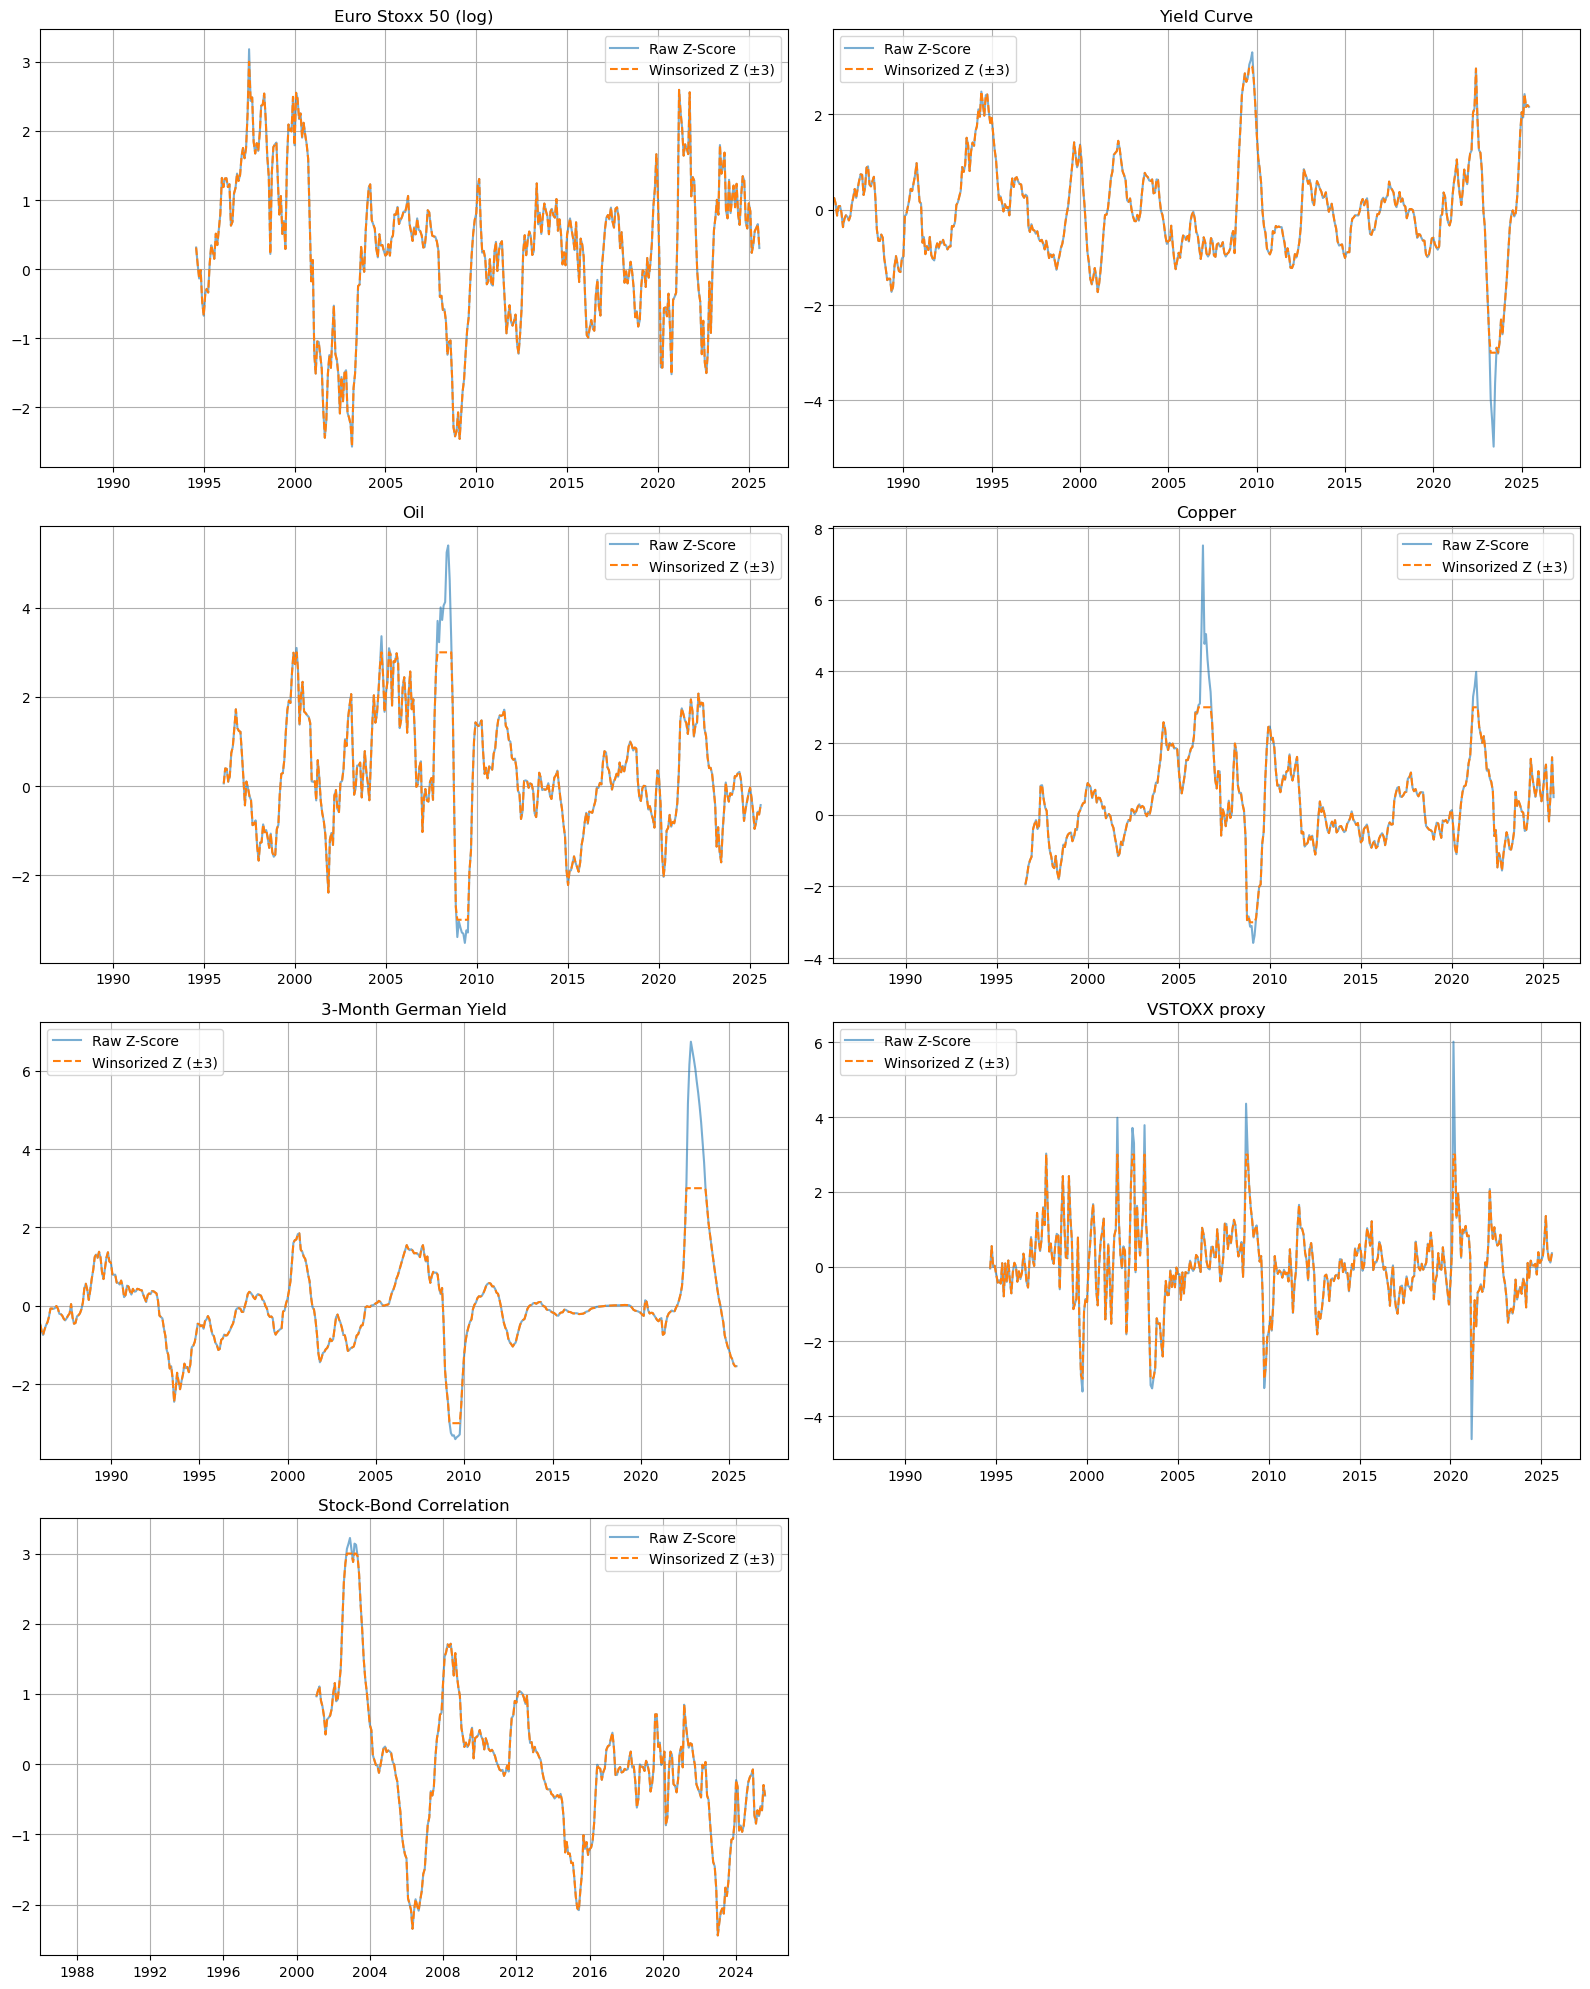

In [3]:
def compute_z_and_winsorized(df, date_col, value_col, window_months=120):
    df = df.copy().sort_values(date_col)
    df["Diff12"]   = df[value_col] - df[value_col].shift(12)
    df["RollStd"]  = (df["Diff12"]
                      .shift(1)
                      .rolling(window_months, min_periods=80)
                      .std())
    df["ZScore"]   = df["Diff12"] / df["RollStd"]
    df["ZScoreWinsorized"] = df["ZScore"].clip(-3, 3)
    return df[[date_col, "ZScore", "ZScoreWinsorized"]]

series_info_eur = {
    "Euro Stoxx 50 (log)":    ("eurostoxx_log",   var_mkt_eur,   "Month", "Log_EuroStoxx"),
    "Yield Curve":            ("yield_curve",     merged_eur,    "Month", "YieldCurve"),
    "Oil":                    ("oil",             oil_monthly_eur,"Month", "Oil Price"),
    "Copper":                 ("copper",          copper_monthly_eur,"Month","Copper"),
    "3-Month German Yield":   ("three_month",     var_3m_eur,    "Month", "ThreeMonth"),
    "VSTOXX proxy":           ("vstoxx",          combined_vol_eur,"Month","VolProxy"),
    "Stock-Bond Correlation": ("stockbond_corr",  var_correl_eur,"Month", "StockBondCorr"),
}

fig, axes = plt.subplots(4, 2, figsize=(16, 20))
axes = axes.flatten()

for i, (title, (_, df, date_col, value_col)) in enumerate(series_info_eur.items()):
    z_df = compute_z_and_winsorized(df, date_col, value_col)
    axes[i].plot(z_df[date_col].dt.to_timestamp(), z_df["ZScore"],
                 label="Raw Z-Score", alpha=0.6)
    axes[i].plot(z_df[date_col].dt.to_timestamp(), z_df["ZScoreWinsorized"],
                 label="Winsorized Z (±3)", ls="--")
    axes[i].set_title(title)
    axes[i].set_xlim(left=pd.Timestamp("1986-01-01"))
    axes[i].grid(True)
    axes[i].legend()

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


In [4]:
market_monthly_eur = (var_mkt_eur
    .loc[:, ["Month", "Log_EuroStoxx"]]
    .rename(columns={"Log_EuroStoxx": "Value"}))

yield_monthly_eur  = (merged_eur
    .loc[:, ["Month", "YieldCurve"]]
    .rename(columns={"YieldCurve": "Value"}))

oil_monthly_clean_eur    = oil_monthly_eur.rename(columns={"Oil Price": "Value"})
copper_monthly_clean_eur = copper_monthly_eur.rename(columns={"Copper": "Value"})

monthly_3m_eur  = (var_3m_eur
    .loc[:, ["Month", "ThreeMonth"]]
    .rename(columns={"ThreeMonth": "Value"}))

vix_monthly_clean_eur = combined_vol_eur.rename(columns={"VolProxy": "Value"})

stockbond_monthly_eur = (var_correl_eur
    .loc[:, ["Month", "StockBondCorr"]]
    .rename(columns={"StockBondCorr": "Value"}))

series_dict_eur = {
    "Market":              market_monthly_eur,
    "Yield curve":         yield_monthly_eur,
    "Oil":                 oil_monthly_clean_eur,
    "Copper":              copper_monthly_clean_eur,
    "3-M German Yield":    monthly_3m_eur,
    "VSTOXX proxy":        vix_monthly_clean_eur,
    "Stock-Bond Corr":     stockbond_monthly_eur,
}


series_info_eur = {
    "Euro Stoxx 50 (log)": ("eurostoxx_log",   var_mkt_eur,   "Month", "Log_EuroStoxx"),
    "Yield curve":         ("yield_curve",     merged_eur,    "Month", "YieldCurve"),
    "Oil":                 ("oil",             oil_monthly_eur,"Month","Oil Price"),
    "Copper":              ("copper",          copper_monthly_eur,"Month","Copper"),
    "3-M German Yield":    ("three_month",     var_3m_eur,    "Month", "ThreeMonth"),
    "VSTOXX proxy":        ("vstoxx",          combined_vol_eur,"Month","VolProxy"),
    "Stock-Bond Corr":     ("stockbond_corr",  var_correl_eur,"Month", "StockBondCorr"),
}

rows   = []
lags   = [1, 3, 12, 36, 120]  
for title, (_, df, date_col, value_col) in series_info_eur.items():

    zdf = (compute_z_and_winsorized(df, date_col, value_col)
           .dropna(subset=["ZScoreWinsorized"])
           .reset_index(drop=True))

    if len(zdf) < max(lags) + 1:
        acs      = [np.nan] * len(lags)
        mean_z   = np.nan
        std_z    = np.nan
    else:
        acs      = [zdf["ZScoreWinsorized"].autocorr(lag=l) for l in lags]
        mean_z   = zdf["ZScoreWinsorized"].mean()
        std_z    = zdf["ZScoreWinsorized"].std(ddof=1)

    rows.append({
        "Variable":     title,
        "1 month":      acs[0],
        "3 month":      acs[1],
        "12 month":     acs[2],
        "3 year":       acs[3],
        "10 year":      acs[4],
        "monthly mean": mean_z,
        "std":          std_z,
        "frequency":    "monthly",
    })

summary_table_eur = (pd.DataFrame(rows)
    .loc[:, ["Variable", "1 month", "3 month", "12 month",
             "3 year", "10 year", "monthly mean", "std", "frequency"]])

numeric_cols = ["1 month", "3 month", "12 month", "3 year",
                "10 year", "monthly mean", "std"]
summary_table_eur[numeric_cols] = summary_table_eur[numeric_cols].round(2)

summary_table_eur

,Variable,1 month,3 month,12 month,3 year,10 year,monthly mean,std,frequency
0,Euro Stoxx 50 (log),0.93,0.79,0.10,-0.17,0.06,0.29,1.08,monthly
1,Yield curve,0.96,0.82,-0.15,0.06,-0.07,-0.04,1.11,monthly
2,Oil,0.93,0.74,-0.14,0.11,-0.10,0.28,1.32,monthly
3,Copper,0.95,0.79,0.04,-0.02,-0.04,0.25,1.18,monthly
4,3-M German Yield,0.98,0.88,0.10,-0.00,0.12,-0.01,1.08,monthly
5,VSTOXX proxy,0.73,0.34,-0.32,-0.02,0.16,0.04,1.02,monthly
6,Stock-Bond Corr,0.98,0.90,0.38,-0.37,0.31,-0.03,1.05,monthly


In [5]:
def find_similar_months(
    df_period: pd.DataFrame,
    target: str,
    exclude_last_n: int = 36,
    bottom_pct: float = 0.15
) -> pd.DataFrame:
    
    T_period = pd.Period(target, freq='M')

    
    cutoff_period = T_period - exclude_last_n  

    mask = df_period.index <= cutoff_period

    df_candidates = df_period.loc[mask].copy()

    df_candidates = df_candidates.dropna(how='any')

    z_T = df_period.loc[T_period].values   

    mat = df_candidates.values               
    diffs = mat - z_T.reshape(1, -1)        
    sq    = diffs**2
    dist  = np.sqrt(sq.sum(axis=1))          

    out = pd.DataFrame({
        'Distance': dist
    }, index=df_candidates.index)

    out = out.sort_values('Distance', ascending=True)
    out['Rank'] = np.arange(1, len(out) + 1)
    n_select = int(np.floor(bottom_pct * len(out)))
    n_select = max(n_select, 1)  
    out['IsBottom'] = False
    out.iloc[:n_select, out.columns.get_indexer(['IsBottom'])] = True

    result_df = out.reset_index().rename(columns={'index': 'Month'})

    return result_df

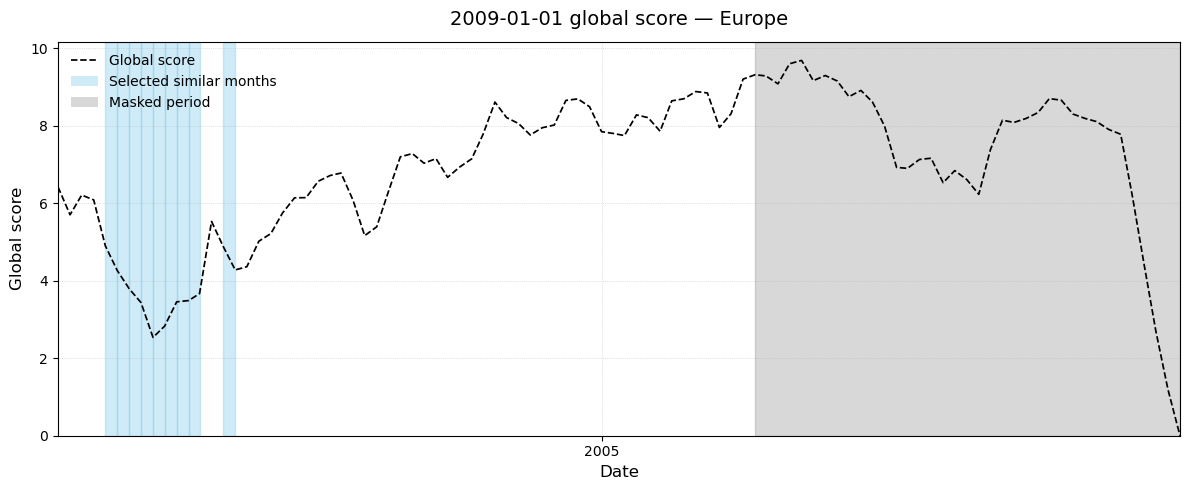

In [29]:
if "Month" in df_period_eur.columns:
    df_period_eur = df_period_eur.set_index("Month")


target_month   = "2009-01"   
bottom_pct     = 0.15        
exclude_last_n = 36         

sim_tbl_full = find_similar_months(
    df_period=df_period_eur,
    target=target_month,
    exclude_last_n=0,         
    bottom_pct=bottom_pct,
)

sim_tbl_masked = find_similar_months(
    df_period=df_period_eur,
    target=target_month,
    exclude_last_n=exclude_last_n,
    bottom_pct=bottom_pct,
)

ts_dist = (
    sim_tbl_full.set_index("Month")["Distance"]
                .sort_index()
                .rename("Global score")
)
ts_dist.index = ts_dist.index.to_timestamp(how="end")

selected = sim_tbl_masked[sim_tbl_masked["IsBottom"]].copy()
selected["start"] = selected["Month"].dt.to_timestamp(how="start")
selected["end"]   = selected["Month"].dt.to_timestamp(how="end")

T_period      = pd.Period(target_month, freq="M")
cutoff_period = T_period - exclude_last_n
mask_start_ts = (cutoff_period + 1).to_timestamp(how="start")
mask_end_ts   = T_period.to_timestamp(how="end")




plt.figure(figsize=(12, 5))
ax = plt.gca()

# main line
ax.plot(ts_dist.index, ts_dist.values,
        linestyle="--", color="black", linewidth=1.25,
        label="Global score")

for _, row in selected.iterrows():
    ax.axvspan(row["start"], row["end"], color="skyblue", alpha=0.4)

ax.axvspan(mask_start_ts, mask_end_ts, color="gray", alpha=0.3)

proxy_sim  = Rectangle((0, 0), 1, 1, facecolor="skyblue", alpha=0.4)
proxy_mask = Rectangle((0, 0), 1, 1, facecolor="gray",    alpha=0.3)
ax.legend(handles=[ax.lines[0], proxy_sim, proxy_mask],
          labels=["Global score",
                  "Selected similar months",
                  "Masked period"],
          loc="upper left", frameon=False)

ax.set_title(f"{target_month}-01 global score — Europe", fontsize=14, pad=12)
ax.set_ylabel("Global score", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylim(bottom=0)
ax.set_xlim(left=ts_dist.index.min(), right=ts_dist.index.max())
ax.grid(which="major", linestyle=":", linewidth=0.5, alpha=0.7)
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


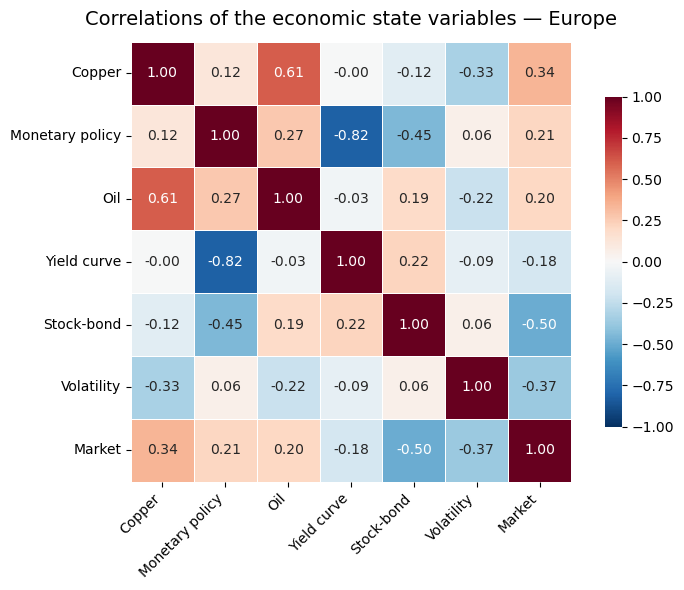

In [30]:

z_market  = (compute_z_and_winsorized(market_monthly_eur,      "Month", "Value")
             .rename(columns={"ZScoreWinsorized": "Market"})[["Month", "Market"]])

z_yield   = (compute_z_and_winsorized(yield_monthly_eur,       "Month", "Value")
             .rename(columns={"ZScoreWinsorized": "Yield curve"})[["Month", "Yield curve"]])

z_oil     = (compute_z_and_winsorized(oil_monthly_clean_eur,   "Month", "Value")
             .rename(columns={"ZScoreWinsorized": "Oil"})[["Month", "Oil"]])

z_copper  = (compute_z_and_winsorized(copper_monthly_clean_eur,"Month", "Value")
             .rename(columns={"ZScoreWinsorized": "Copper"})[["Month", "Copper"]])

z_3m      = (compute_z_and_winsorized(monthly_3m_eur,          "Month", "Value")
             .rename(columns={"ZScoreWinsorized": "Monetary policy"})[["Month", "Monetary policy"]])

z_vix     = (compute_z_and_winsorized(vix_monthly_clean_eur,   "Month", "Value")
             .rename(columns={"ZScoreWinsorized": "Volatility"})[["Month", "Volatility"]])

z_sb      = (compute_z_and_winsorized(stockbond_monthly_eur,   "Month", "Value")
             .rename(columns={"ZScoreWinsorized": "Stock-bond"})[["Month", "Stock-bond"]])

df_period_eur = (z_market
    .merge(z_yield, on="Month", how="outer")
    .merge(z_oil,   on="Month", how="outer")
    .merge(z_copper,on="Month", how="outer")
    .merge(z_3m,    on="Month", how="outer")
    .merge(z_vix,   on="Month", how="outer")
    .merge(z_sb,    on="Month", how="outer"))

corr_mat_eur = df_period_eur.drop(columns="Month").corr()

row_order = [
    "Copper",
    "Monetary policy",
    "Oil",
    "Yield curve",
    "Stock-bond",
    "Volatility",
    "Market",
]
corr_mat_eur = corr_mat_eur.loc[row_order, row_order]


plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_mat_eur,
    annot=True,
    fmt=".2f",
    center=0,
    cmap="RdBu_r",
    vmin=-1, vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75},
)
plt.title("Correlations of the economic state variables — Europe", fontsize=14, pad=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


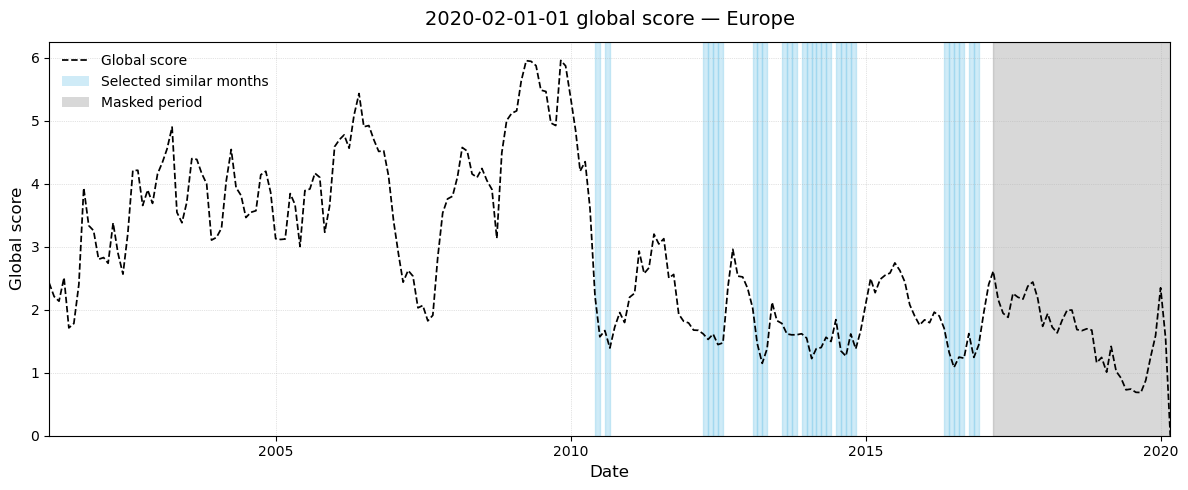

In [31]:
if "Month" in df_period_eur.columns:
    df_period_eur = df_period_eur.set_index("Month")

target_month   = "2020-02-01"  
bottom_pct     = 0.15        
exclude_last_n = 36          

sim_tbl_full = find_similar_months(
    df_period=df_period_eur,
    target=target_month,
    exclude_last_n=0,         
    bottom_pct=bottom_pct,
)

sim_tbl_masked = find_similar_months(
    df_period=df_period_eur,
    target=target_month,
    exclude_last_n=exclude_last_n,
    bottom_pct=bottom_pct,
)

ts_dist = (
    sim_tbl_full.set_index("Month")["Distance"]
                .sort_index()
                .rename("Global score")
)
ts_dist.index = ts_dist.index.to_timestamp(how="end")

selected = sim_tbl_masked[sim_tbl_masked["IsBottom"]].copy()
selected["start"] = selected["Month"].dt.to_timestamp(how="start")
selected["end"]   = selected["Month"].dt.to_timestamp(how="end")

T_period      = pd.Period(target_month, freq="M")
cutoff_period = T_period - exclude_last_n
mask_start_ts = (cutoff_period + 1).to_timestamp(how="start")
mask_end_ts   = T_period.to_timestamp(how="end")


plt.figure(figsize=(12, 5))
ax = plt.gca()

ax.plot(ts_dist.index, ts_dist.values,
        linestyle="--", color="black", linewidth=1.25,
        label="Global score")

for _, row in selected.iterrows():
    ax.axvspan(row["start"], row["end"], color="skyblue", alpha=0.4)

ax.axvspan(mask_start_ts, mask_end_ts, color="gray", alpha=0.3)

proxy_sim  = Rectangle((0, 0), 1, 1, facecolor="skyblue", alpha=0.4)
proxy_mask = Rectangle((0, 0), 1, 1, facecolor="gray",    alpha=0.3)
ax.legend(handles=[ax.lines[0], proxy_sim, proxy_mask],
          labels=["Global score",
                  "Selected similar months",
                  "Masked period"],
          loc="upper left", frameon=False)

ax.set_title(f"{target_month}-01 global score — Europe", fontsize=14, pad=12)
ax.set_ylabel("Global score", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylim(bottom=0)
ax.set_xlim(left=ts_dist.index.min(), right=ts_dist.index.max())
ax.grid(which="major", linestyle=":", linewidth=0.5, alpha=0.7)
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [32]:


ff_5f = pd.read_csv("Regimes\Data\Europe\Europe_5_Factors.csv",skiprows=3,engine='python').rename(columns={"Unnamed: 0": "Date"}) 
ff_mom = pd.read_csv("Regimes\Data\Europe\Europe_MOM_Factor.csv",skiprows=3,engine='python').rename(columns={"Unnamed: 0": "Date"}) 

In [33]:

concat_fff = (
    pd.merge(ff_5f, ff_mom, on="Date", how="inner")      # raw join
      .rename(columns={"WML": "Mom"})    # clarify cols
      .assign(Date=lambda d: d["Date"].astype(str).str.strip())# ensure str
      .loc[lambda d: d["Date"].str.fullmatch(r"\d{6}")]        # keep YYYYMM rows
)

concat_fff["Month"] = pd.to_datetime(concat_fff["Date"], format="%Y%m").dt.to_period("M")
concat_fff = concat_fff.set_index("Month").drop(columns="Date").sort_index()

factor_cols = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "Mom"]
concat_fff[factor_cols] = concat_fff[factor_cols].apply(pd.to_numeric, errors="coerce") / 100
concat_fff["RF"]        = pd.to_numeric(concat_fff["RF"], errors="coerce") / 100

print(concat_fff.head())



         Mkt-RF     SMB     HML     RMW     CMA      RF     Mom
Month                                                          
1991-07  0.0530 -0.0322 -0.0035  0.0271 -0.0049  0.0049  0.0506
1991-08  0.0142 -0.0096 -0.0008  0.0277  0.0021  0.0046  0.0377
1991-09  0.0302  0.0178 -0.0005  0.0270 -0.0053  0.0046  0.0423
1991-12  0.0630 -0.0385 -0.0210  0.0119 -0.0131  0.0038  0.0193
1992-04  0.0502 -0.0135 -0.0007  0.0261  0.0190  0.0032  0.0188


<Figure size 1200x650 with 0 Axes>

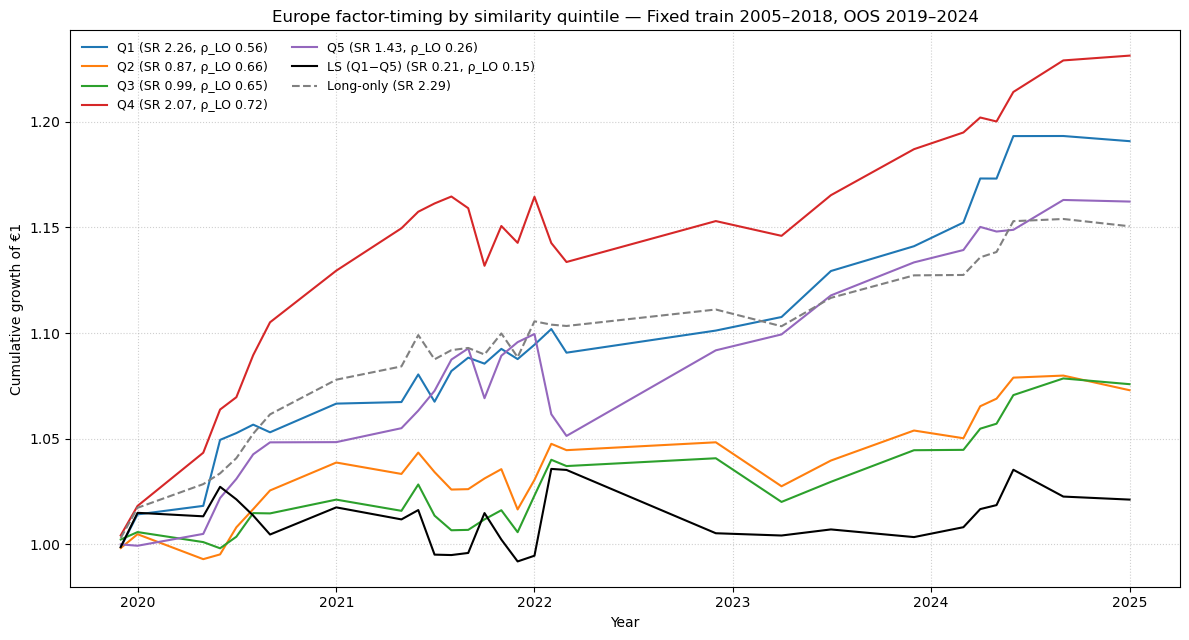

            Ann. Return  Ann. Vol  Ann. Sharpe  Corr vs LO  Max DD  N days
Q1               0.0750    0.0324       2.2551      0.5583 -0.0119    29.0
Q2               0.0295    0.0341       0.8722      0.6633 -0.0258    29.0
Q3               0.0307    0.0310       0.9917      0.6503 -0.0220    29.0
Q4               0.0899    0.0421       2.0722      0.7157 -0.0282    29.0
Q5               0.0642    0.0443       1.4294      0.2551 -0.0439    29.0
LS (Q1−Q5)       0.0087    0.0462       0.2095      0.1467 -0.0344    29.0
Long-only        0.0598    0.0255       2.2907      1.0000 -0.0104    29.0


In [40]:
# --- Add these constants (fixed train / OOS) ---
TRAIN_START = pd.Period('2005-01', freq='M')
TRAIN_END   = pd.Period('2018-12', freq='M')
OOS_START   = pd.Period('2019-01', freq='M')
OOS_END     = pd.Period('2024-12', freq='M')

# --- Replace your quintile_members with this train-filtered version ---
def quintile_members(df_period: pd.DataFrame, target_per: pd.Period):
    full = (find_similar_months(df_period, str(target_per),
                                exclude_last_n=lookback_gap,
                                bottom_pct=1.0)
            .sort_values('Distance'))

    if full.empty:
        return {q: np.array([]) for q in range(1, 6)}

    # Ensure Period dtype and FILTER to fixed training pool only
    if not isinstance(full['Month'].dtype, pd.PeriodDtype):
        full['Month'] = pd.PeriodIndex(full['Month'], freq='M')
    full = full[(full['Month'] >= TRAIN_START) & (full['Month'] <= TRAIN_END)]

    n = len(full)
    if n == 0:
        return {q: np.array([]) for q in range(1, 6)}

    k20         = int(0.20 * n) if n >= 5 else max(int(np.floor(0.20*n)), 1)
    if k20*2 > n:  # tiny n: put everything in the middle bucket
        return {1: np.array([]), 2: np.array([]), 3: full['Month'].to_numpy(), 4: np.array([]), 5: np.array([])}

    q1          = full.iloc[:k20]['Month'].to_numpy()
    q5          = full.iloc[-k20:]['Month'].to_numpy()
    mid         = full.iloc[k20:-k20]['Month'].to_numpy()
    q2, q3, q4  = np.array_split(mid, 3) if len(mid) >= 3 else (np.array([]), mid, np.array([]))
    return {1: q1, 2: q2, 3: q3, 4: q4, 5: q5}

# --- Keep your signal_for_quintile unchanged ---

# --- Replace your backtest range setup + loop with strict OOS bounds ---
all_months = concat_fff.index.sort_values()
oos_months = all_months[(all_months >= OOS_START) & (all_months <= OOS_END)]

# require next-month return -> iterate to penultimate OOS month
returns_by_q = {q: [] for q in range(1, 6)}
for i in range(len(oos_months) - 1):
    cur_per, nxt_per = oos_months[i], oos_months[i+1]
    r = concat_fff.loc[nxt_per, factors]

    for q in range(1, 6):
        sig = signal_for_quintile(df_period_eur, cur_per, q)
        # (optional) avoid diluting with zero-signals:
        active = [f for f, s in sig.items() if s != 0]
        ret = float(np.mean([sig[f] * r[f] for f in (active or factors)]))  # falls back to all if none active
        returns_by_q[q].append({'Date': nxt_per, 'Return': ret})

q_df = {q: pd.DataFrame(lst).set_index('Date').sort_index() for q, lst in returns_by_q.items()}

# Align start across quintiles
common_idx = None
for q in range(1, 6):
    idx = q_df[q].index
    common_idx = idx if common_idx is None else common_idx.intersection(idx)
first_trd = common_idx.min()
for q in q_df:
    q_df[q] = q_df[q].loc[first_trd:]

# Long-only benchmark (same OOS window)
long_only = (
    concat_fff[factors]
      .mean(axis=1)
      .loc[first_trd:]
      .reindex(q_df[1].index)
      .dropna()
)
# =====================================================================
# Aggregate: add Long–Short (Q1−Q5), compute stats, and plot everything
# =====================================================================
def ann_sr(x):
    s = x.std()
    return (x.mean()/s)*np.sqrt(12) if s and s!=0 else np.nan

def ann_ret(x):
    n = len(x)
    return (1 + x).prod()**(12.0/n) - 1 if n > 0 else np.nan

def ann_vol(x):
    return x.std()*np.sqrt(12)

def max_dd(x):
    eq = (1+x).cumprod()
    return (eq/eq.cummax() - 1.0).min()


# Build aligned returns for all portfolios
ports = {
    'Q1': q_df[1]['Return'].astype(float),
    'Q2': q_df[2]['Return'].astype(float),
    'Q3': q_df[3]['Return'].astype(float),
    'Q4': q_df[4]['Return'].astype(float),
    'Q5': q_df[5]['Return'].astype(float),
    'Long-only': long_only.astype(float)
}
ls_tmp = pd.concat([ports['Q1'], ports['Q5']], axis=1, keys=['Q1','Q5']).dropna()
ports['LS (Q1−Q5)'] = (ls_tmp['Q1'] - ls_tmp['Q5']).rename('LS (Q1−Q5)')

# Align everyone to a common index for apples-to-apples stats
common_idx_all = None
for s in ports.values():
    common_idx_all = s.index if common_idx_all is None else common_idx_all.intersection(s.index)
ports = {k: v.loc[common_idx_all] for k,v in ports.items()}

# Metrics table
rows = {}
lo_aligned = ports['Long-only']
for name, s in ports.items():
    rows[name] = {
        'Ann. Return': ann_ret(s),
        'Ann. Vol':    ann_vol(s),
        'Ann. Sharpe': ann_sr(s),
        'Corr vs LO':  s.corr(lo_aligned),
        'Max DD':      max_dd(s),
        'N days':      int(len(s)),
    }
summary_df = pd.DataFrame(rows).T.loc[['Q1','Q2','Q3','Q4','Q5','LS (Q1−Q5)','Long-only']]

# Plot
cum = lambda x: (1+x).cumprod()
plt.figure(figsize=(12, 6.5))

# Plot
cum = lambda x: (1+x).cumprod()
plt.figure(figsize=(12, 6.5))

for q, col in zip([1,2,3,4,5], ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']):
    s  = ports[f'Q{q}']
    sr = summary_df.loc[f'Q{q}', 'Ann. Sharpe']
    rho= summary_df.loc[f'Q{q}', 'Corr vs LO']
    plt.plot(s.index.to_timestamp(how='end'),  # <-- convert Period[M] -> Timestamp
             cum(s),
             label=f"Q{q} (SR {sr:.2f}, \u03C1_LO {rho:.2f})",
             color=col)

sr_ls  = summary_df.loc['LS (Q1−Q5)', 'Ann. Sharpe']
rho_ls = summary_df.loc['LS (Q1−Q5)', 'Corr vs LO']
plt.plot(ports['LS (Q1−Q5)'].index.to_timestamp(how='end'),
         cum(ports['LS (Q1−Q5)']),
         label=f"LS (Q1−Q5) (SR {sr_ls:.2f}, \u03C1_LO {rho_ls:.2f})",
         color='black')

sr_lo = summary_df.loc['Long-only', 'Ann. Sharpe']
plt.plot(ports['Long-only'].index.to_timestamp(how='end'),
         cum(ports['Long-only']),
         ls='--', color='gray',
         label=f"Long-only (SR {sr_lo:.2f})")

plt.title("Europe factor-timing by similarity quintile — Fixed train 2005–2018, OOS 2019–2024")
plt.xlabel("Year"); plt.ylabel("Cumulative growth of €1")
plt.grid(ls=":", alpha=.6)
ax = plt.gca()
ax.legend(frameon=False, fontsize=9, ncols=2)
ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()

# Final metrics
print(summary_df.round(4))

# (rest of your stats/plot code is fine)


In [35]:
import numpy as np
import pandas as pd
from numpy.linalg import inv, LinAlgError

def find_similar_months_maha(
    df_period: pd.DataFrame,
    target: str,
    exclude_last_n: int = 36,
    bottom_pct: float = 0.15,
    ridge: float = 1e-8        
) -> pd.DataFrame:
    """
    Same signature / output as the Euclidean version, but uses
    Mahalanobis distance:  d(i) = √((x_i – x_T)^T Σ⁻¹ (x_i – x_T))
    where Σ is the sample covariance matrix of the candidate set.
    """
    T_period = pd.Period(target, freq="M")

    cutoff_period = T_period - exclude_last_n
    df_candidates = (df_period
                     .loc[df_period.index <= cutoff_period]
                     .dropna(how="any")
                     .copy())

    if df_candidates.empty:
        raise ValueError("No candidate months left after masking NA / look-back.")

    X = df_candidates.values
    try:
        inv_cov = inv(np.cov(X, rowvar=False))
    except LinAlgError:
        Σ = np.cov(X, rowvar=False)
        Σ += ridge * np.eye(Σ.shape[0])
        inv_cov = inv(Σ)

    x_T = df_period.loc[T_period].values.reshape(1, -1)
    diffs = X - x_T                             # (n, k)
    d2    = np.einsum("ij,jk,ik->i", diffs, inv_cov, diffs)  # quadratic form
    dist  = np.sqrt(d2)

    out = (pd.DataFrame({"Distance": dist}, index=df_candidates.index)
             .sort_values("Distance"))
    out["Rank"] = np.arange(1, len(out) + 1)

    n_select = max(int(np.floor(bottom_pct * len(out))), 1)
    out["IsBottom"] = False
    out.iloc[:n_select, out.columns.get_loc("IsBottom")] = True

    return out.reset_index().rename(columns={"index": "Month"})


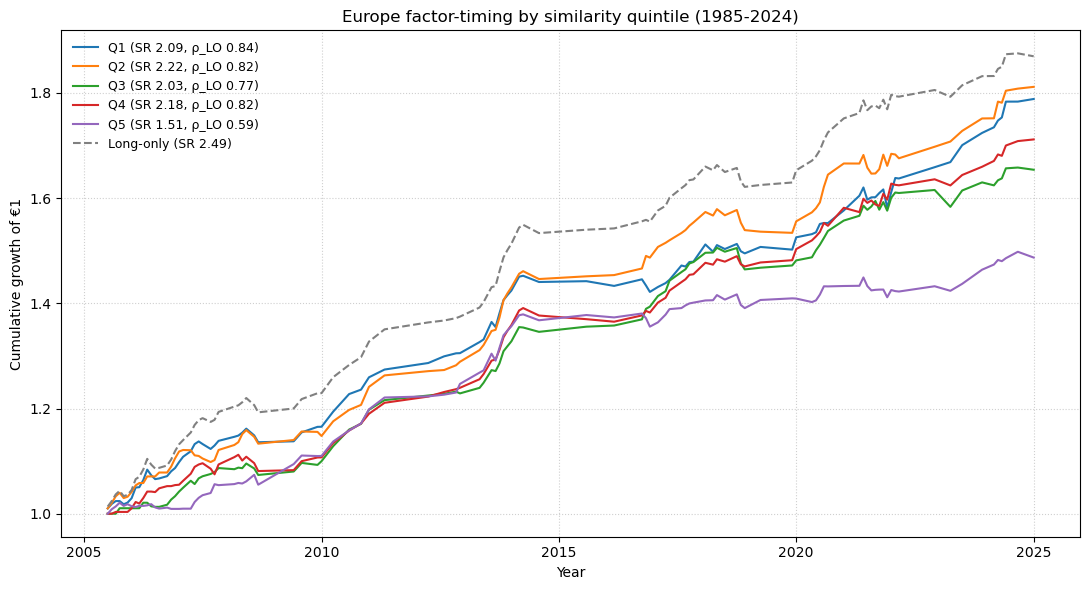

In [36]:
lookback_gap = 36                      
factors      = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Mom']
colors       = {1:"tab:blue", 2:"tab:orange", 3:"tab:green",
                4:"tab:red", 5:"tab:purple"}

BACKTEST_START = pd.Period('2005-01', freq='M')
BACKTEST_END   = pd.Period('2024-12', freq='M')

def quintile_members(df_period: pd.DataFrame, target_per: pd.Period):
    full = (find_similar_months_maha(df_period, str(target_per),
                                exclude_last_n=lookback_gap,
                                bottom_pct=1.0)
            .sort_values('Distance'))

    n = len(full)
    if n == 0:
        return {q: np.array([]) for q in range(1, 6)}

    k20         = int(0.20 * n)
    q1          = full.iloc[:k20]['Month'].to_numpy()
    q5          = full.iloc[-k20:]['Month'].to_numpy()
    mid         = full.iloc[k20:-k20]['Month'].to_numpy()
    q2, q3, q4  = np.array_split(mid, 3)

    return {1: q1, 2: q2, 3: q3, 4: q4, 5: q5}

def signal_for_quintile(df_period, target_per, quintile):
    months = quintile_members(df_period, target_per)[quintile]
    if len(months) == 0:
        return {f: 0 for f in factors}

    idx   = pd.PeriodIndex(months, freq='M') + 1      
    signs = {}
    for f in factors:
        rets      = concat_fff.loc[concat_fff.index.intersection(idx), f]
        signs[f]  = np.sign(rets.mean()) if not rets.empty else 0
    return signs

first_possible = df_period_eur.index.min() + (lookback_gap + 1)
hist_start     = max(BACKTEST_START, first_possible)
hist_end       = min(BACKTEST_END,   concat_fff.index.max())

all_months = concat_fff.index.sort_values()
start_idx  = next(i for i, p in enumerate(all_months) if p >= hist_start)
stop_idx   = next(i for i, p in enumerate(all_months) if p >  hist_end) - 1

returns_by_q = {q: [] for q in range(1, 6)}

for i in range(start_idx, stop_idx):
    cur_per, nxt_per = all_months[i], all_months[i+1]
    r = concat_fff.loc[nxt_per, factors]

    for q in range(1, 6):
        sig = signal_for_quintile(df_period_eur, cur_per, q)
        ret = np.mean([sig[f] * r[f] for f in factors])
        returns_by_q[q].append({'Date': nxt_per, 'Return': ret})

q_df = {q: pd.DataFrame(lst).set_index('Date') for q, lst in returns_by_q.items()}

common_idx = q_df[1].dropna().index
for q in range(2, 6):
    common_idx = common_idx.intersection(q_df[q].dropna().index)

first_trd = common_idx.min()

for q in q_df:
    q_df[q] = q_df[q].loc[first_trd:]

long_only = (
    concat_fff[factors]
      .mean(axis=1)
      .loc[first_trd:]
      .reindex(q_df[1].index)       
      .dropna()
)



ann_sr  = lambda x: (x.mean() / x.std()) * np.sqrt(12) if x.std() != 0 else np.nan
corr_lo = lambda x: x.corr(long_only)

stats = {q: (ann_sr(df['Return']), corr_lo(df['Return'])) for q, df in q_df.items()}
sr_lo = ann_sr(long_only)

cum = lambda x: (1 + x).cumprod()

plt.figure(figsize=(11, 6))
for q in range(1, 6):
    plt.plot(q_df[q].index.to_timestamp(how='end'),
             cum(q_df[q]['Return']),
             color=colors[q],
             label=f"Q{q} (SR {stats[q][0]:.2f}, ρ_LO {stats[q][1]:.2f})")

plt.plot(q_df[1].index.to_timestamp(how='end'),
         cum(long_only), color='gray', ls='--',
         label=f"Long-only (SR {sr_lo:.2f})")

plt.title("Europe factor-timing by similarity quintile (1985-2024)")
plt.xlabel("Year")
plt.ylabel("Cumulative growth of €1")
plt.legend(frameon=False, fontsize=9)
plt.grid(ls=":", alpha=.6)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()

In [10]:

ff_5f = pd.read_csv("Regimes\Data\Europe\Europe_5_Factors_Daily.csv",skiprows=3,engine='python').rename(columns={"Unnamed: 0": "Date"}) 
ff_mom = pd.read_csv("Regimes\Data\Europe\Europe_MOM_Factor_Daily.csv",skiprows=3,engine='python').rename(columns={"Unnamed: 0": "Date"}) 
state_var = pd.read_excel("Regimes\Data\Europe\state_z_europe.xlsx")

In [14]:
factors = (
    pd.merge(ff_5f, ff_mom, on="Date", how="inner")
      .rename(columns={"WML": "Mom"})  # if your momentum col is named WML
      .assign(Date=lambda d: d["Date"].astype(str).str.strip())
      .loc[lambda d: d["Date"].str.fullmatch(r"\d{8}")]  # keep YYYYMMDD rows
)

factors["Date"] = pd.to_datetime(factors["Date"], format="%Y%m%d", errors="coerce")
factors = (
    factors
      .dropna(subset=["Date"])
      .sort_values("Date")
      .drop_duplicates(subset=["Date"])
      .set_index("Date")
)

factor_cols = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "Mom"]
for c in factor_cols + ["RF"]:
    if c in factors:
        factors[c] = pd.to_numeric(factors[c], errors="coerce") / 100.0



In [17]:
import pandas as pd
import numpy as np

# ---------- helpers (unchanged) ----------
def _to_period_m_from_col(df: pd.DataFrame, col: str) -> pd.DataFrame:
    if col not in df.columns:
        raise ValueError(f"Expected column '{col}' not found.")
    s = df[col]
    if isinstance(getattr(s, "dtype", None), pd.PeriodDtype):
        per = s.astype("period[M]")
    else:
        per = pd.to_datetime(s, errors="coerce").dt.to_period("M")
    out = df.copy()
    out = out.assign(**{col: per}).dropna(subset=[col]).set_index(col).sort_index()
    return out

def _to_period_m_from_index(df: pd.DataFrame) -> pd.DataFrame:
    idx = df.index
    if isinstance(idx, pd.PeriodIndex):
        if str(idx.freq) != "M":
            idx = idx.asfreq("M")
        out = df.copy()
        out.index = idx
        return out.sort_index()
    elif isinstance(idx, pd.DatetimeIndex):
        out = df.copy()
        out.index = idx.to_period("M")
        return out.sort_index()
    else:
        out = df.copy()
        out.index = pd.to_datetime(out.index, errors="coerce").to_period("M")
        return out.dropna(axis=0, how="all").sort_index()

# ---------- FACTORS version ----------
def prep_inputs_factors(factors: pd.DataFrame, macro_df: pd.DataFrame, keep_dates_col: bool = True):
    """
    Prepare a cross section of *factors* instead of countries.
    Returns: fac_ret_daily, fac_ret_monthly, factor_months, assets, df_m
    """

    fac = factors.copy()

    # Ensure Dates col or DatetimeIndex
    if "Dates" in fac.columns:
        fac["Dates"] = pd.to_datetime(fac["Dates"], errors="coerce")
        fac = fac.dropna(subset=["Dates"]).sort_values("Dates")
        fac = fac.set_index("Dates", drop=not keep_dates_col)
    elif isinstance(fac.index, pd.DatetimeIndex):
        fac = fac.sort_index()
        if keep_dates_col and "Dates" not in fac.columns:
            fac = fac.copy()
            fac["Dates"] = fac.index
    else:
        raise ValueError("`factors` must have a 'Dates' column or a DatetimeIndex.")

    # Factor columns = numeric only
    assets = [c for c in fac.columns if c != "Dates" and pd.api.types.is_numeric_dtype(fac[c])]
    if not assets:
        raise ValueError("No numeric factor columns found.")

    # Daily returns (already returns if FF data, but keep pipeline generic)
    fac_ret_daily = fac[assets].pct_change()
    fac_ret_daily = fac_ret_daily.replace([np.inf, -np.inf], np.nan).dropna(how="all")

    # Monthly compounding
    fac_ret_monthly = (1.0 + fac_ret_daily).resample("ME").prod() - 1.0
    fac_ret_monthly.index = fac_ret_monthly.index.to_period("M")
    factor_months = fac_ret_monthly.index.sort_values()

    # Macro panel align
    Z = macro_df.copy()
    if "Month" in Z.columns:
        Z = _to_period_m_from_col(Z, "Month")
    else:
        Z = _to_period_m_from_index(Z)

    macro_cols = [c for c in Z.columns if pd.api.types.is_numeric_dtype(Z[c])]
    if not macro_cols:
        raise ValueError("No numeric macro columns found in the z-score panel.")
    Z = Z[macro_cols].astype(float)

    full_grid = pd.period_range(Z.index.min(), Z.index.max(), freq="M")
    Z = Z.reindex(full_grid).ffill()
    Z = Z.reindex(factor_months).ffill()

    return fac_ret_daily, fac_ret_monthly, factor_months, assets, Z

# You can run this entire block multiple times without breaking columns/indexes.
sec_ret_daily, sec_ret_monthly, sector_months, assets, df_m = prep_inputs_countries(factors, state_var, keep_dates_col=True)

# Train/OOS windows (idempotent)
TRAIN_START, TRAIN_END = pd.Period('2005-01','M'), pd.Period('2018-12','M')
OOS_START,   OOS_END   = pd.Period('2019-01','M'), pd.Period('2024-12','M')

df_train = df_m.loc[(df_m.index >= TRAIN_START) & (df_m.index <= TRAIN_END)]
if df_train.dropna(how='any').empty:
    raise ValueError("Training window 2005–2018 has no fully non-NaN rows in df_train.")

oos_stop = min(OOS_END, sector_months.max())
months_bt = sector_months[(sector_months >= OOS_START) & (sector_months <= oos_stop)]
if len(months_bt) < 2:
    raise ValueError(
        f"No OOS months to backtest. sector_months {sector_months.min()}..{sector_months.max()}, "
        f"requested OOS {OOS_START}..{OOS_END}"
    )

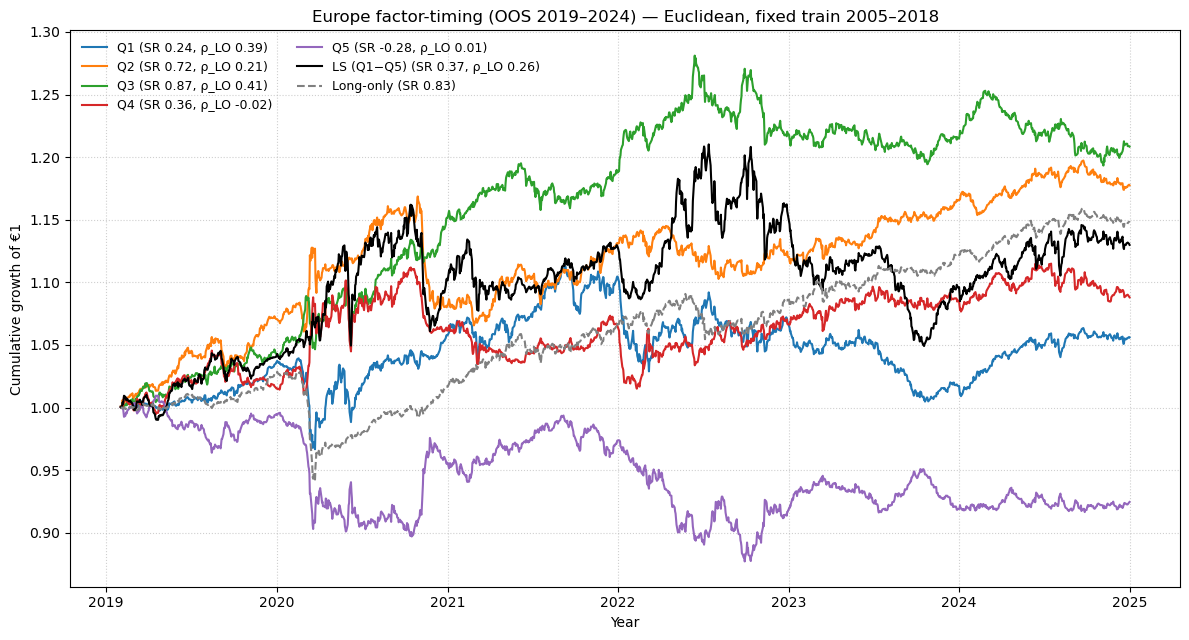

            Ann. Return  Ann. Vol  Ann. Sharpe  Corr vs LO  Max DD  N days
Q1               0.0089    0.0409       0.2382      0.3901 -0.0970  1543.0
Q2               0.0271    0.0381       0.7188      0.2093 -0.0882  1543.0
Q3               0.0314    0.0365       0.8652      0.4099 -0.0685  1543.0
Q4               0.0139    0.0402       0.3629     -0.0239 -0.0871  1543.0
Q5              -0.0127    0.0424      -0.2808      0.0138 -0.1312  1543.0
LS (Q1−Q5)       0.0202    0.0581       0.3726      0.2645 -0.1331  1543.0
Long-only        0.0228    0.0275       0.8330      1.0000 -0.0838  1543.0


In [25]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Load your inputs (with explicit date parsing) ---
ff_5f  = pd.read_csv(r"Regimes\Data\Europe\Europe_5_Factors_Daily.csv", skiprows=3, engine="python") \
           .rename(columns={"Unnamed: 0": "Dates"})
ff_mom = pd.read_csv(r"Regimes\Data\Europe\Europe_MOM_Factor_Daily.csv", skiprows=3, engine="python") \
           .rename(columns={"Unnamed: 0": "Dates"})

# Parse YYYYMMDD integers/strings → proper datetimes
for df in (ff_5f, ff_mom):
    df["Dates"] = pd.to_datetime(df["Dates"].astype(str), format="%Y%m%d", errors="coerce")
for df in (ff_5f, ff_mom):
    df.iloc[:, 1:] = df.iloc[:, 1:].astype(float) / 100.0

# Merge & sort
factors = (ff_5f.merge(ff_mom, on="Dates", how="outer")
                 .dropna(subset=["Dates"])
                 .sort_values("Dates")
                 .reset_index(drop=True))

state_var = pd.read_excel(r"Regimes\Data\Europe\state_z_europe.xlsx")



# ---------- helpers ----------
def _to_period_m_from_col(df: pd.DataFrame, col: str) -> pd.DataFrame:
    if col not in df.columns:
        raise ValueError(f"Expected column '{col}' not found.")
    s = df[col]
    dt = pd.to_datetime(s, errors="coerce")
    per = dt.dt.to_period("M")          # ← fix: use .dt.to_period
    out = df.copy()
    out = out.assign(**{col: per}).dropna(subset=[col]).set_index(col).sort_index()
    return out


def _to_period_m_from_index(df: pd.DataFrame) -> pd.DataFrame:
    idx = df.index
    if isinstance(idx, pd.PeriodIndex):
        if str(idx.freq) != "M":
            idx = idx.asfreq("M")
        out = df.copy()
        out.index = idx
        return out.sort_index()
    elif isinstance(idx, pd.DatetimeIndex):
        out = df.copy()
        out.index = idx.to_period("M")
        return out.sort_index()
    else:
        out = df.copy()
        out.index = pd.to_datetime(out.index, errors="coerce").to_period("M")
        return out.dropna(axis=0, how="all").sort_index()

# ---------- FACTORS version ----------
def prep_inputs_factors(factors: pd.DataFrame, macro_df: pd.DataFrame, keep_dates_col: bool = True):
    """
    Prepare a cross section of *factors* (columns are factors; rows are daily dates).
    Assumes factor files are already daily returns (e.g., FF data).
    Returns: fac_ret_daily, fac_ret_monthly, factor_months, assets, Z
    """
    fac = factors.copy()

    # Ensure Dates col + DatetimeIndex
    if "Dates" not in fac.columns:
        raise ValueError("`factors` must have a 'Dates' column.")
    fac["Dates"] = pd.to_datetime(fac["Dates"], errors="coerce")
    fac = fac.dropna(subset=["Dates"]).sort_values("Dates")
    fac = fac.set_index("Dates", drop=not keep_dates_col)
    if keep_dates_col and "Dates" not in fac.columns:
        fac["Dates"] = fac.index

    # Factor columns = numeric only (exclude the copy of Dates col)
    assets = [c for c in fac.columns if c != "Dates" and pd.api.types.is_numeric_dtype(fac[c])]
    if not assets:
        raise ValueError("No numeric factor columns found.")

    # FF are already returns -> use as-is
    fac_ret_daily = fac[assets].astype(float)
    fac_ret_daily = fac_ret_daily.replace([np.inf, -np.inf], np.nan).dropna(how="all")

    # Monthly compounding
    fac_ret_monthly = (1.0 + fac_ret_daily).resample("ME").prod() - 1.0
    fac_ret_monthly.index = fac_ret_monthly.index.to_period("M")
    factor_months = fac_ret_monthly.index.sort_values()

    # Macro panel align
    Z = macro_df.copy()
    if "Month" in Z.columns:
        Z = _to_period_m_from_col(Z, "Month")
    else:
        Z = _to_period_m_from_index(Z)

    macro_cols = [c for c in Z.columns if pd.api.types.is_numeric_dtype(Z[c])]
    if not macro_cols:
        raise ValueError("No numeric macro columns found in the z-score panel.")
    Z = Z[macro_cols].astype(float)

    full_grid = pd.period_range(Z.index.min(), Z.index.max(), freq="M")
    Z = Z.reindex(full_grid).ffill()
    Z = Z.reindex(factor_months).ffill()

    return fac_ret_daily, fac_ret_monthly, factor_months, assets, Z

# --- Prepare inputs (factors + macro) ---
fac_ret_daily, fac_ret_monthly, factor_months, assets, df_m = prep_inputs_factors(factors, state_var, keep_dates_col=True)

# --- Train/OOS windows ---
TRAIN_START, TRAIN_END = pd.Period('2005-01','M'), pd.Period('2018-12','M')
OOS_START,   OOS_END   = pd.Period('2019-01','M'), pd.Period('2024-12','M')

df_train = df_m.loc[(df_m.index >= TRAIN_START) & (df_m.index <= TRAIN_END)]
if df_train.dropna(how='any').empty:
    raise ValueError("Training window 2005–2018 has no fully non-NaN rows in df_train.")

oos_stop = min(OOS_END, factor_months.max())
months_bt = factor_months[(factor_months >= OOS_START) & (factor_months <= oos_stop)]
if len(months_bt) < 2:
    raise ValueError(
        f"No OOS months to backtest. factor_months {factor_months.min()}..{factor_months.max()}, "
        f"requested OOS {OOS_START}..{OOS_END}"
    )

# =====================================================================
# Euclidean distance on a FIXED training set (2005–2018), OOS 2019–2024
# =====================================================================
def days_in_period(idx_daily: pd.DatetimeIndex, per: pd.Period):
    return idx_daily[idx_daily.to_period('M') == per]

def find_similar_months_euclid_fixed_train(
    df_full: pd.DataFrame,     # all features incl. target month (monthly macro Z)
    df_train: pd.DataFrame,    # ONLY candidate pool (2005–2018)
    target: str,
    bottom_pct: float = 1.0
) -> pd.DataFrame:
    T = pd.Period(target, 'M')
    if T not in df_full.index:
        prior = df_full.index[df_full.index < T]
        if len(prior) == 0:
            return pd.DataFrame(columns=['Month','Distance','Rank','IsBottom'])
        T = prior.max()

    # Require complete rows in the training pool
    candidates = df_train.dropna(how='any')
    if candidates.empty:
        return pd.DataFrame(columns=['Month','Distance','Rank','IsBottom'])

    # Euclidean distance
    X   = candidates.values
    x_T = df_full.loc[T].values.reshape(1, -1)
    dist = np.linalg.norm(X - x_T, axis=1)

    out = (pd.DataFrame({'Distance': dist}, index=candidates.index)
             .sort_values('Distance'))
    out['Rank'] = np.arange(1, len(out) + 1)
    n_select = max(int(np.floor(bottom_pct * len(out))), 1)
    out['IsBottom'] = False
    out.iloc[:n_select, out.columns.get_loc('IsBottom')] = True
    return out.reset_index().rename(columns={'index':'Month'})

def _label_col(df):
    if 'Month' in df.columns: return 'Month'
    if 'Dates' in df.columns: return 'Dates'
    return df.columns[0]

def quintile_members_euclid_fixed(target_per: pd.Period):
    full = (find_similar_months_euclid_fixed_train(df_m, df_train, str(target_per), bottom_pct=1.0)
            .sort_values('Distance'))
    if full.empty:
        return {q: np.array([]) for q in range(1,6)}
    lab = _label_col(full)
    n   = len(full); k20 = int(0.20*n)
    if k20 == 0:
        return {1: np.array([]), 2: np.array([]), 3: full[lab].to_numpy(), 4: np.array([]), 5: np.array([])}
    q1  = full.iloc[:k20][lab].to_numpy()
    q5  = full.iloc[-k20:][lab].to_numpy()
    mid = full.iloc[k20:-k20][lab].to_numpy()
    if len(mid) >= 3:
        q2, q3, q4 = np.array_split(mid, 3)
    else:
        q2, q3, q4 = np.array([]), mid, np.array([])
    return {1:q1, 2:q2, 3:q3, 4:q4, 5:q5}

def signal_for_quintile_euclid_fixed(target_per: pd.Period, quintile: int):
    """
    Sign of the *next-month* average return for each factor
    computed over the months in the chosen quintile.
    """
    months = quintile_members_euclid_fixed(target_per)[quintile]
    if len(months) == 0:
        return {a: 0 for a in assets}
    idx = pd.PeriodIndex(months, freq='M') + 1   # use returns in the month AFTER each similar month
    signs = {}
    for a in assets:
        r = fac_ret_monthly.loc[fac_ret_monthly.index.intersection(idx), a]
        signs[a] = np.sign(r.mean()) if not r.empty else 0
    return signs

# --- Backtest daily ---
returns_by_q = {q: [] for q in range(1,6)}

for i in range(len(months_bt)-1):
    cur_per, nxt_per = months_bt[i], months_bt[i+1]
    dts = days_in_period(fac_ret_daily.index, nxt_per)
    if len(dts) == 0:
        continue
    Rm = fac_ret_daily.loc[dts, assets].astype(float)

    for q in range(1,6):
        sigs = signal_for_quintile_euclid_fixed(cur_per, q)
        # active assets only (avoid diluting by zeros)
        active = [a for a, s in sigs.items() if s != 0]
        if len(active) == 0:
            # flat (0) for the days in nxt_per
            for dt in dts:
                returns_by_q[q].append({'Date': dt, 'Return': 0.0})
            continue
        w = pd.Series({a: sigs[a] for a in active}, dtype=float)
        Rm_active = Rm[active].fillna(0.0)
        port_daily = (Rm_active.mul(w, axis=1)).mean(axis=1)  # equal-weight among active
        returns_by_q[q].extend([{'Date': dt, 'Return': float(ret)} for dt, ret in port_daily.items()])

q_df = {q: pd.DataFrame(lst).set_index('Date').sort_index() for q, lst in returns_by_q.items()}

# Align start across all quintiles
common_idx = None
for q in range(1,6):
    idx = q_df[q].index
    common_idx = idx if common_idx is None else common_idx.intersection(idx)
first_trd = common_idx.min()
for q in q_df:
    q_df[q] = q_df[q].loc[first_trd:]

# Long-only equal-weight daily across factors (reference)
long_only = fac_ret_daily[assets].mean(axis=1).loc[first_trd:].reindex(q_df[1].index).dropna()

# =====================================================================
# Aggregate: add Long–Short (Q1−Q5), compute stats, and plot everything
# =====================================================================
def ann_sr(x):
    s = x.std()
    return (x.mean()/s)*np.sqrt(252) if s and s!=0 else np.nan
def ann_ret(x):
    n = len(x)
    return (1 + x).prod()**(252.0/n) - 1 if n > 0 else np.nan
def ann_vol(x):
    return x.std()*np.sqrt(252)
def max_dd(x):
    eq = (1+x).cumprod()
    return (eq/eq.cummax() - 1.0).min()

# Build aligned returns for all portfolios
ports = {
    'Q1': q_df[1]['Return'].astype(float),
    'Q2': q_df[2]['Return'].astype(float),
    'Q3': q_df[3]['Return'].astype(float),
    'Q4': q_df[4]['Return'].astype(float),
    'Q5': q_df[5]['Return'].astype(float),
    'Long-only': long_only.astype(float)
}
ls_tmp = pd.concat([ports['Q1'], ports['Q5']], axis=1, keys=['Q1','Q5']).dropna()
ports['LS (Q1−Q5)'] = (ls_tmp['Q1'] - ls_tmp['Q5']).rename('LS (Q1−Q5)')

# Align everyone to a common index for apples-to-apples stats
common_idx_all = None
for s in ports.values():
    common_idx_all = s.index if common_idx_all is None else common_idx_all.intersection(s.index)
ports = {k: v.loc[common_idx_all] for k,v in ports.items()}

# Metrics table
rows = {}
lo_aligned = ports['Long-only']
for name, s in ports.items():
    rows[name] = {
        'Ann. Return': ann_ret(s),
        'Ann. Vol':    ann_vol(s),
        'Ann. Sharpe': ann_sr(s),
        'Corr vs LO':  s.corr(lo_aligned),
        'Max DD':      max_dd(s),
        'N days':      int(len(s)),
    }
summary_df = pd.DataFrame(rows).T.loc[['Q1','Q2','Q3','Q4','Q5','LS (Q1−Q5)','Long-only']]

# Plot
cum = lambda x: (1+x).cumprod()
plt.figure(figsize=(12, 6.5))

for q, col in zip([1,2,3,4,5], ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']):
    s  = ports[f'Q{q}']
    sr = summary_df.loc[f'Q{q}', 'Ann. Sharpe']
    rho= summary_df.loc[f'Q{q}', 'Corr vs LO']
    plt.plot(s.index, cum(s), label=f"Q{q} (SR {sr:.2f}, \u03C1_LO {rho:.2f})", color=col)

sr_ls  = summary_df.loc['LS (Q1−Q5)', 'Ann. Sharpe']
rho_ls = summary_df.loc['LS (Q1−Q5)', 'Corr vs LO']
plt.plot(ports['LS (Q1−Q5)'].index, cum(ports['LS (Q1−Q5)']),
         label=f"LS (Q1−Q5) (SR {sr_ls:.2f}, \u03C1_LO {rho_ls:.2f})", color='black')

sr_lo = summary_df.loc['Long-only', 'Ann. Sharpe']
plt.plot(ports['Long-only'].index, cum(ports['Long-only']), ls='--',
         label=f"Long-only (SR {sr_lo:.2f})", color='gray')

plt.title("Europe factor-timing (OOS 2019–2024) — Euclidean, fixed train 2005–2018")
plt.xlabel("Year"); plt.ylabel("Cumulative growth of €1")
plt.grid(ls=":", alpha=.6)
ax = plt.gca()
ax.legend(frameon=False, fontsize=9, ncols=2)
ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()

# Final metrics
print(summary_df.round(4))
